In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
from time import time
from math import floor

In [2]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

In [3]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [4]:
dataset_path = './data.csv'
dataset = pd.read_csv(dataset_path)

event_nums = dataset['event_num'].unique()
seq_list = []

for num in event_nums:
    df = dataset[dataset['event_num'] == num]
    df = df.drop(columns='event_num')
    df = df.to_numpy()
    seq_list.append(df)

In [5]:
#inp_len, tar_len <= 5

def generate_xy(seq, loc, inp_len, tar_len):
    inp_start_idx = loc
    inp_end_idx = loc+inp_len
    
    tar_start_idx = loc+inp_len
    tar_end_idx = tar_start_idx+tar_len
    
    tar2_start_idx = tar_start_idx+1
    tar2_end_idx = tar_end_idx+1
    
    inp = seq[inp_start_idx:inp_end_idx]
    tar = seq[tar_start_idx:tar_end_idx]
    tar2 = seq[tar2_start_idx:tar2_end_idx]
    
    inp_padding_size = int(5-inp.shape[0])
    tar_padding_size = int(5-tar.shape[0])  #same for tar and tar2
    
    inp = np.pad(inp, ((0, inp_padding_size), (0, 0)), 'constant', constant_values=0)
    tar = np.pad(tar, ((0, tar_padding_size), (0, 0)), 'constant', constant_values=0)
    tar2 = np.pad(tar2, ((0, tar_padding_size), (0, 0)), 'constant', constant_values=0)
    
    return (inp, tar), tar2

In [6]:
X = []
Y = []
Y_real = []
for seq in seq_list:
    iter_num = int(len(seq)-10)
    for loc in range(iter_num):
        lengths = [3, 4, 5]
        inp_len = choice(lengths)
        tar_len = choice(lengths)
        (inp, tar), tar2 = generate_xy(seq, loc, inp_len, tar_len)
        X.append(inp)
        Y.append(tar)
        Y_real.append(tar2)
        
X = np.asarray(X)
Y = np.asarray(Y)
Y_real = np.asarray(Y_real)

In [7]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [8]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [9]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size) 
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  

        output = self.dense(concat_attention)

        return output, attention_weights

In [11]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x+attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1+ffn_output)
        
        return out2

In [13]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1+x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2+out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output+out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [14]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x

In [15]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
        return x, attention_weights

In [16]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, pe_input, pe_target, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(d_model)
        
    def call(self, inputs, training):
        inp, tar = inputs
        
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
    
    def unembed(self, seq):
        shape = seq.shape
        seq = tf.reduce_sum(seq, axis=2)
        return seq
    
    def create_masks(self, inp, tar):
        inp = self.unembed(inp)
        tar = self.unembed(tar)
        
        enc_padding_mask = create_padding_mask(inp)
        dec_padding_mask = create_padding_mask(inp)
        
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
    
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
        return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [17]:
num_layers = 2
d_model = 6
dff = 4096
num_heads = 2
dropout_rate = 0

In [18]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [19]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [20]:
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [21]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [22]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [29]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [30]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
]


@tf.function(input_signature=train_step_signature)
def train_step(X, Y, Y_real):
    with tf.GradientTape() as tape:
        predictions, _ = transformer([X, Y], training=True)
        loss = loss_function(Y_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)

In [25]:
EPOCHS = 50

In [37]:
batch_size = 100
steps_num = len(X)/batch_size
steps_num = floor(steps_num)
last_batch_size = len(X)-batch_size*steps_num
last_batch_size = int(last_batch_size)

for epoch in range(EPOCHS):
    start = time()
    
    train_loss.reset_states()
    
    for batch_num in range(steps_num):
        x = X[batch_num*batch_size:(batch_num+1)*batch_size]
        y = Y[batch_num*batch_size:(batch_num+1)*batch_size]
        y_real = Y_real[batch_num*batch_size:(batch_num+1)*batch_size]
        train_step(x, y, y_real)
        
    x = X[steps_num*batch_size:steps_num*batch_size+last_batch_size]
    y = Y[steps_num*batch_size:steps_num*batch_size+last_batch_size]
    y_real = Y_real[steps_num*batch_size:steps_num*batch_size+last_batch_size]
    train_step(x, y, y_real)
    
    if (epoch+1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    
        print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}')

        print(f'Time taken for 1 epoch: {time() - start:.2f} secs\n')

KeyboardInterrupt: 

In [31]:
def predictions(idx, count):
    x = X[idx:idx+1]
    y = Y[idx:idx+1]
    
    y_zero_idx = None
    x_zero_idx = None
    
    for i in range(5):
        x_not_pad = np.sum(x[0][i])
        y_not_pad = np.sum(y[0][i])
        
        if x_not_pad:
            x_cor = np.reshape(x[0][i][0:4], (2, 2))
            x_cor = x_cor.T
            plt.plot(x_cor[0], x_cor[1], 'ro')
        elif x_zero_idx == None and abs(x_not_pad) < 0.1:
            x_zero_idx = i
        
        if y_not_pad:
            y_cor = np.reshape(y[0][i][0:4], (2, 2))
            y_cor = y_cor.T
            plt.plot(y_cor[0], y_cor[1], 'bo')
        elif y_zero_idx == None and abs(y_not_pad) < 0.1:
            y_zero_idx = i
            
    for i in range(count):
        x_zero_idx = None
        y_zero_idx = None
        
        for a in range(5):
            x_not_pad = np.sum(x[0][a])
            if abs(x_not_pad) < 0.1:
                x_zero_idx = a
                break
        
        for a in range(5):
            y_not_pad = np.sum(y[0][a])
            if abs(y_not_pad) < 0.1:
                y_zero_idx = a
                break
        
        prediction, _ = transformer([x, y], training=False)
        prediction = prediction[0][0:y_zero_idx]
        prediction = prediction[-1]
        prediction_cor = prediction[0:4]
        prediction_cor = np.reshape(prediction_cor, (2, 2))
        plt.plot(*prediction_cor[0], 'go')
        plt.plot(*prediction_cor[1], 'yo')
        
        newx = np.zeros((5, 6))
        newy = np.zeros((5, 6))
        
        if x_zero_idx == None:
            newx[0:4] = x[0][1:5]
            newx[4] = y[0][0]
        else:
            newx[0:x_zero_idx] = x[0][0:x_zero_idx]
            newx[x_zero_idx:] = y[0][0:5-x_zero_idx]
            
        if y_zero_idx == None:
            newy[0:4] = y[0][1:5]
            newy[4] = prediction
        else:
            newy[0:y_zero_idx-1] = y[0][1:y_zero_idx]
            newy[y_zero_idx-1:y_zero_idx] = prediction
        
        x = np.reshape(newx, (1, 5, 6))
        y = np.reshape(newy, (1, 5, 6))
        
    plt.show()

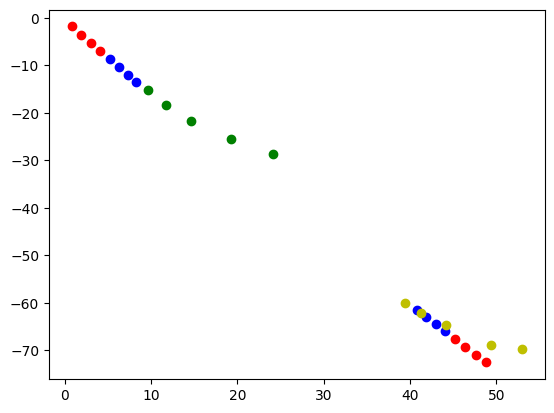

In [42]:
predictions(984, 5)

In [33]:
def display_seq(x, y, seq):
    y_zero_idx = None
    
    for i, a in enumerate(x):
        
        if sum(a) == 0:
            break
            
        x_cor = a[0:4]
        x_cor = np.reshape(x_cor, (2, 2))
        plt.plot(*x_cor[0], 'ro')
        plt.plot(*x_cor[1], 'bo')
        
    for i, a in enumerate(y):
        
        if sum(a) == 0:
            y_zero_idx = i
            break
            
        y_cor = a[0:4]
        y_cor = np.reshape(y_cor, (2, 2))
        plt.plot(*y_cor[0], 'ro')
        plt.plot(*y_cor[1], 'bo')
        
    for i, a in enumerate(seq):
        
        if i == y_zero_idx:
            break
            
        if sum(a) == 0:
            break
        
        seq_cor = a[0:4]
        seq_cor = np.reshape(seq_cor, (2, 2))
        plt.plot(*seq_cor[0], 'go')
        plt.plot(*seq_cor[1], 'yo')

In [34]:
def usage(idx):
    x = X[idx:idx+1]
    y = Y[idx:idx+1]
    test_result, _ = transformer([x, y], training=False)
    test_result = test_result.numpy()
    test_result = np.reshape(test_result, (5, 6))
    x = np.reshape(x, (5, 6))
    y = np.reshape(y, (5, 6))
    display_seq(x, y, test_result)
    print(test_result)
    print(Y_real[idx])
    plt.show()

In [35]:
def usage2(idx):
    x = X[idx:idx+1]
    y = Y[idx:idx+1]
    y_real = Y_real[idx:idx+1]
    x = np.reshape(x, (5, 6))
    y = np.reshape(y, (5, 6))
    y_real = np.reshape(y_real, (5, 6))
    display_seq(x, y, y_real)
    plt.show()

In [36]:
def usage3(idx):
    x = X[idx:idx+1]
    y = Y[idx:idx+1]
    x = np.reshape(x, (5, 6))
    y = np.reshape(y, (5, 6))
    display_seq(x, y, np.zeros((5, 6)))
    plt.show()

[[  5.498316   13.192311  -31.193071  -45.309414    2.1747925   2.179882 ]
 [  7.5627127  14.6120205 -27.637297  -40.914974    2.3426244   2.3488626]
 [  9.329331   15.8896475 -24.171524  -36.541977    2.4988933   2.5063686]
 [ 10.787852   17.340487  -20.838678  -32.515244    2.6239743   2.6323473]
 [ 12.227553   19.082146  -17.68647   -28.216877    2.7338388   2.7425766]]
[[  6.40990034  13.00737268 -31.23611066 -46.5202284    2.28387205
    2.40988098]
 [  7.92920259  14.32784747 -27.88838188 -42.17260368   2.28387205
    2.40988098]
 [  9.41891796  15.62260734 -24.56456901 -37.85603806   2.28387205
    2.40988098]
 [ 10.87904646  16.8916523  -21.26467208 -33.57053156   2.28387205
    2.40988098]
 [ 12.30958808  18.13498234 -17.98869108 -29.31608417   2.28387205
    2.40988098]]


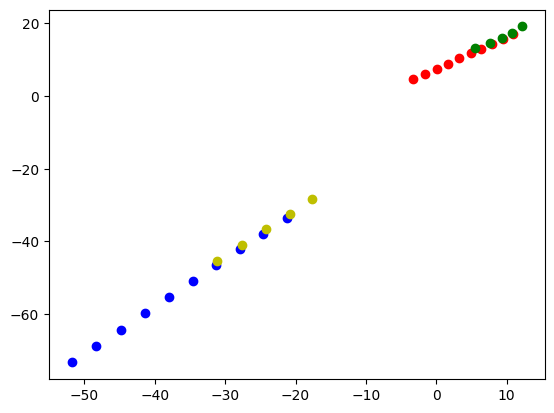

In [43]:
usage(435)

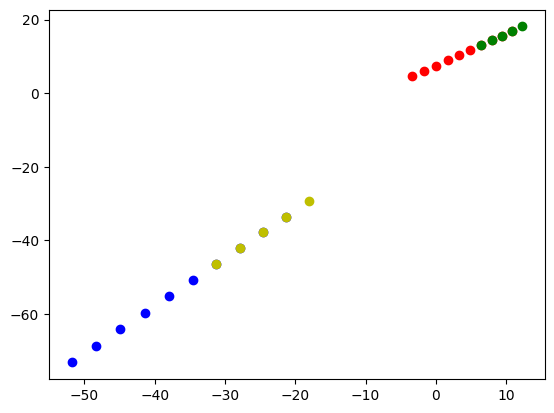

In [44]:
usage2(435)

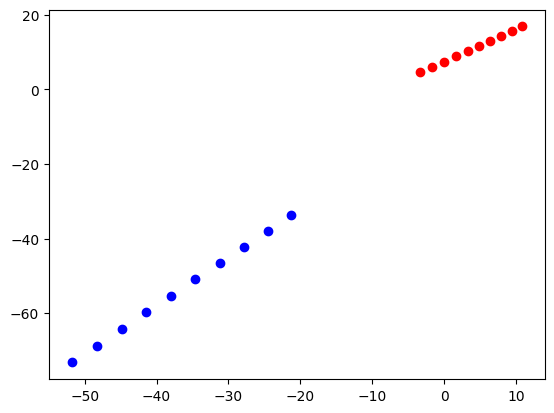

In [45]:
usage3(435)